# Stochastic Parameter Decomposition

## Imports

In [ ]:
# import all the torch stuff, as well as the ViT stuff and such
# import plotly.express as px
# import torch
# from jaxtyping import Int, Float
# from typing import List, Optional, Tuple
# from tqdm import tqdm
# from transformer_lens.hook_points import HookPoint
# from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
# import circuitsvis as cv

In [81]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import einops
import typing
from tqdm import tqdm

## Toy Model MLP

In [1]:
# create a SPDHookedTransformer Class
# that extends the hookedTransformer
# which inherits all the previous class stuff
# but also contains the SPD training algo?

# how is everything actually structured? 
"""
Maybe I should start with implementing it on a simple MLP setup. 

Orig network:
- 1 layer MLP 5-2-5 (defined as usual with torch.Sequential presumably)

SPD network:
let's give it 10 subcomponents per layer
then it's just like 10 matmuls? 
maybe i should define it like ant did in the toy models of superposition paper
stick them all into a trenchcoat
this might be easier once I have defined the toy modle

"""

In [82]:
"""config = {
    "num_layers": 1,
    "pre_embed_size": 100,
    "in_size": 1000,
    "hidden_size": 50,
    "subcomponents_per_layer": 10, 
    "beta_1": 1, 
    "beta_2": 1, 
    "beta_3": 1, 
    "causal_imp_min": 1, 
    "num_mask_samples": 20,
    "importance_mlp_size": 10,
}"""

In [352]:
class ToyResidMLP(nn.Module):
    def __init__(self, config, device="cpu"):
        super().__init__()
        # Initialize Weights for the
        self.num_layers, self.pre_embed_size, self.in_size, self.hidden_size = config["num_layers"], config["pre_embed_size"], config["in_size"], config["hidden_size"]
        self.device = device
        self.W_embed = nn.Parameter(torch.empty((self.pre_embed_size, self.in_size)))
        self.W_unembed = nn.Parameter(torch.empty((self.in_size, self.pre_embed_size)))
        self.W_in = nn.ParameterList([torch.empty((self.in_size, self.hidden_size), device=device) for i in range(self.num_layers)])
        self.W_out = nn.ParameterList([torch.empty((self.hidden_size, self.in_size), device=device) for i in range(self.num_layers)])
        self.b = nn.ParameterList([torch.zeros((self.hidden_size,), device=device) for i in range(self.num_layers)])

        for param in [self.W_embed, self.W_unembed] + list(self.W_in) + list(self.W_out): 
            nn.init.xavier_normal_(param)
        
    def forward(self, x): 
        
        assert x.shape[1] == self.pre_embed_size, f"Input shape {x.shape[0]} does not match model's accepted size {self.pre_embed_size}"
        # embed 
        x_resid = torch.einsum("np,pi->ni", x.clone(), self.W_embed)
        N, D = x_resid.shape

        
        for l in range(self.num_layers):
            hidden = F.relu(torch.einsum("nd,dh -> nh", x_resid, self.W_in[l]) + self.b[l])
            layer_out = torch.einsum("nh,hd -> nd", hidden, self.W_out[l])
            x_resid = x_resid + layer_out
        # am I supposed to have a embed and out?
        x_out = torch.einsum("ni,ip->np", x_resid, self.W_unembed) 
        return x_out


# Generated by LLM bc I am lazy and this is not important to me learning stuff atm
class SparseAutoencoderDataset(Dataset):
    """
    Dataset for learning to reconstruct sparse inputs.
    Each item is (input, target) where target is the input itself (or ReLU of input).
    """
    def __init__(self, in_dim=100, n_samples=10000, sparsity=0.9, device="cpu"):
        super().__init__()
        self.in_dim = in_dim
        self.n_samples = n_samples
        self.device = device

        # Pre-generate all samples
        self.inputs = []
        self.targets = []
        
        for _ in range(n_samples):
            # Sparse input: each entry is -1, 0, or 1, with sparsity
            x = np.random.choice([0, -1, 1], size=(in_dim,), p=[1-sparsity, sparsity/2, sparsity/2])
            x = torch.tensor(x, dtype=torch.float32, device=device)
            target = F.relu(x)
            
            self.inputs.append(x)
            self.targets.append(target)
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def train_toy_resid_mlp(
    model,
    dataloader,
    lr=1e-3,
    num_epochs=10,
    device="cpu",
    print_every=1
):
    model.train()
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        if (epoch+1) % print_every == 0:
            print(f"Epoch {epoch+1}: avg MSE loss = {avg_loss:.6f}")

In [398]:
## LLM-Generated Usage Example

torch.autograd.set_detect_anomaly(True)

if __name__ == "__main__":
    # Config
    # device = "mps" if torch.backends.mps.is_available() else "cpu"
    device = "cpu"
    # Dataset and DataLoader
    # Dataset and DataLoader
    dataset = SparseAutoencoderDataset(
        in_dim=100,
        n_samples=15000,
        sparsity=0.9,
        device=device,
    )
    print(device)
    
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    # Model
    toy_model = ToyResidMLP(config, device=device)
    # Train
    train_toy_resid_mlp(toy_model, dataloader, lr=8e-2, num_epochs=20, device=device)

cpu


Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 112.99it/s]


Epoch 1: avg MSE loss = 760803.597674


Epoch 2/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.87it/s]


Epoch 2: avg MSE loss = 115.016697


Epoch 3/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.95it/s]


Epoch 3: avg MSE loss = 33.442329


Epoch 4/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.85it/s]


Epoch 4: avg MSE loss = 14.987998


Epoch 5/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.83it/s]


Epoch 5: avg MSE loss = 7.736972


Epoch 6/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.97it/s]


Epoch 6: avg MSE loss = 4.379529


Epoch 7/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.80it/s]


Epoch 7: avg MSE loss = 2.664837


Epoch 8/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 111.95it/s]


Epoch 8: avg MSE loss = 1.730946


Epoch 9/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.87it/s]


Epoch 9: avg MSE loss = 1.195875


Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.33it/s]


Epoch 10: avg MSE loss = 0.878234


Epoch 11/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 105.72it/s]


Epoch 11: avg MSE loss = 0.685948


Epoch 12/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 111.28it/s]


Epoch 12: avg MSE loss = 0.568491


Epoch 13/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.68it/s]


Epoch 13: avg MSE loss = 0.498048


Epoch 14/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.48it/s]


Epoch 14: avg MSE loss = 0.456770


Epoch 15/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.65it/s]


Epoch 15: avg MSE loss = 0.434461


Epoch 16/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.37it/s]


Epoch 16: avg MSE loss = 0.423845


Epoch 17/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.47it/s]


Epoch 17: avg MSE loss = 0.420266


Epoch 18/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.62it/s]


Epoch 18: avg MSE loss = 0.420559


Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.61it/s]


Epoch 19: avg MSE loss = 0.422876


Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 113.39it/s]

Epoch 20: avg MSE loss = 0.425854


## SPD Model and Train Function

In [399]:
# generated by LLM

class HardSigmoid(nn.Module):
    """
    Implements the hard sigmoid activation function as described in the paper:
        σ_H(x) = 0 if x <= 0
               = x if 0 < x < 1
               = 1 if x >= 1
    This is equivalent to: torch.clamp(x, min=0.0, max=1.0)
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # Clamp values between 0 and 1
        return torch.clamp(x, min=0.0, max=1.0)


class LowerLeakyHardSigmoid(nn.Module):
    """
    Lower-leaky hard sigmoid: σH,lower(x)
    - 0.01*x if x <= 0 (leaky below 0)
    - x if 0 <= x <= 1 (linear in middle)  
    - 1 if x >= 1 (saturated above 1)
    
    Used for forward pass masks in stochastic reconstruction losses.
    """
    def __init__(self, leak_slope=0.01):
        super().__init__()
        self.leak_slope = leak_slope

    def forward(self, x):
        return torch.where(
            x <= 0, 
            self.leak_slope * x,
            torch.where(
                x >= 1,
                torch.ones_like(x),
                x
            )
        )

class UpperLeakyHardSigmoid(nn.Module):
    """
    Upper-leaky hard sigmoid: σH,upper(x)  
    - 0 if x <= 0 (hard cutoff below 0)
    - x if 0 <= x <= 1 (linear in middle)
    - 1 + 0.01*(x-1) if x >= 1 (leaky above 1)
    
    Used for importance loss computation.
    """
    def __init__(self, leak_slope=0.01):
        super().__init__()
        self.leak_slope = leak_slope

    def forward(self, x):
        return torch.where(
            x <= 0,
            torch.zeros_like(x), 
            torch.where(
                x >= 1,
                1 + self.leak_slope * (x - 1),
                x
            )
        )

# Test the functions
if __name__ == "__main__":
    lower_leaky = LowerLeakyHardSigmoid()
    upper_leaky = UpperLeakyHardSigmoid()
    
    test_vals = torch.tensor([-2.0, -0.5, 0.0, 0.3, 0.7, 1.0, 1.5, 2.0])
    
    print("Input:", test_vals)
    print("Lower-leaky:", lower_leaky(test_vals))
    print("Upper-leaky:", upper_leaky(test_vals))

Input: tensor([-2.0000, -0.5000,  0.0000,  0.3000,  0.7000,  1.0000,  1.5000,  2.0000])
Lower-leaky: tensor([-0.0200, -0.0050,  0.0000,  0.3000,  0.7000,  1.0000,  1.0000,  1.0000])
Upper-leaky: tensor([0.0000, 0.0000, 0.0000, 0.3000, 0.7000, 1.0000, 1.0050, 1.0100])


In [401]:
# generated by LLM

class HardSigmoid(nn.Module):
    """
    Implements the hard sigmoid activation function as described in the paper:
        σ_H(x) = 0 if x <= 0
               = x if 0 < x < 1
               = 1 if x >= 1
    This is equivalent to: torch.clamp(x, min=0.0, max=1.0)
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # Clamp values between 0 and 1
        return torch.clamp(x, min=0.0, max=1.0)


class LowerLeakyHardSigmoid(nn.Module):
    """
    Lower-leaky hard sigmoid: σH,lower(x)
    - 0.01*x if x <= 0 (leaky below 0)
    - x if 0 <= x <= 1 (linear in middle)  
    - 1 if x >= 1 (saturated above 1)
    
    Used for forward pass masks in stochastic reconstruction losses.
    """
    def __init__(self, leak_slope=0.01):
        super().__init__()
        self.leak_slope = leak_slope

    def forward(self, x):
        return torch.where(
            x <= 0, 
            self.leak_slope * x,
            torch.where(
                x >= 1,
                torch.ones_like(x),
                x
            )
        )

class UpperLeakyHardSigmoid(nn.Module):
    """
    Upper-leaky hard sigmoid: σH,upper(x)  
    - 0 if x <= 0 (hard cutoff below 0)
    - x if 0 <= x <= 1 (linear in middle)
    - 1 + 0.01*(x-1) if x >= 1 (leaky above 1)
    
    Used for importance loss computation.
    """
    def __init__(self, leak_slope=0.01):
        super().__init__()
        self.leak_slope = leak_slope

    def forward(self, x):
        return torch.where(
            x <= 0,
            torch.zeros_like(x), 
            torch.where(
                x >= 1,
                1 + self.leak_slope * (x - 1),
                x
            )
        )


class SPDModelMLP(nn.Module): 
    # fix the betas stuff below that's basically a type hint
    def __init__(self, target_model, config, device="cpu"): 
        super().__init__()
        
        print("Devices: ", device, target_model.device)
        self.device = device
        object.__setattr__(self, "target_model", target_model) # sets pointer to target_model without registering its parameters as subsidiary

        self.target_model = target_model
        assert self.device == target_model.device, "Models not on same device"

        self.num_layers, self.pre_embed_size, self.in_size, self.hidden_size, self.imp_hidden_size = config["num_layers"], config["pre_embed_size"], config["in_size"], config["hidden_size"], config["importance_mlp_size"]
        self.C = config["subcomponents_per_layer"]
        self.hypers = dict(list(config.items())[4:]) # sets the "hypers" to contain all the hyperparameters for the model
        
        # Subcomponent vectors, each of shape C by in_size; to be used
        # with outer product to create our low-rank subcomponent matrices
        self.V_embed = nn.Parameter(torch.empty((self.C, self.pre_embed_size,), device=device))
        self.U_embed = nn.Parameter(torch.empty((self.C, self.in_size,), device=device))
        self.V_unembed = nn.Parameter(torch.empty((self.C, self.in_size,), device=device))
        self.U_unembed = nn.Parameter(torch.empty((self.C, self.pre_embed_size,), device=device))

        self.V_in = nn.ParameterList([torch.empty((self.C, self.in_size,), device=device) for i in range(self.num_layers)])
        self.U_in = nn.ParameterList([torch.empty((self.C, self.hidden_size,), device=device) for i in range(self.num_layers)]) 
        self.V_out = nn.ParameterList([torch.empty((self.C, self.hidden_size,), device=device) for i in range(self.num_layers)])
        self.U_out = nn.ParameterList([torch.empty((self.C, self.in_size,), device=device) for i in range(self.num_layers)])        
        
        # idk what you do with the biases lol
        self.b = nn.ParameterList([torch.zeros((self.hidden_size,), device=device) for i in range(self.num_layers)])
        
        # this is so horrible I'm sorry
        # gate_in_in is the gate_in weights for the in subcomponent of each layer
        # gate_in_out is gate_in weights for the out component
        # they each get an extra one on the end which is for the embed matrix
        # Probably should have just registered these as submodels, but I didn't know that those existed before.
        self.imp_W_gate_in_in = nn.ParameterList([torch.empty((self.C, 1, self.imp_hidden_size), device=device) for i in range(self.num_layers+1)])
        self.imp_W_gate_out_in = nn.ParameterList([torch.empty((self.C, self.imp_hidden_size, 1), device=device) for i in range(self.num_layers+1)]) 
        self.imp_b_in_in = nn.ParameterList([torch.empty((self.C, self.imp_hidden_size), device=device) for i in range(self.num_layers+1)])
        self.imp_b_out_in = nn.ParameterList([torch.empty((self.C, 1), device=device) for i in range(self.num_layers+1)])
        
        self.imp_W_gate_in_out = nn.ParameterList([torch.empty((self.C, 1, self.imp_hidden_size), device=device) for i in range(self.num_layers+1)])
        self.imp_W_gate_out_out = nn.ParameterList([torch.empty((self.C, self.imp_hidden_size, 1), device=device) for i in range(self.num_layers+1)]) 
        self.imp_b_in_out = nn.ParameterList([torch.empty((self.C, self.imp_hidden_size), device=device) for i in range(self.num_layers+1)])
        self.imp_b_out_out = nn.ParameterList([torch.empty((self.C, 1), device=device) for i in range(self.num_layers+1)])
        
        # self.pred_weights = torch.empty((num_layers, self.C), device=device)

        for param in self.parameters():
            # using xavier anyway -- note that the variance etc is
            # changed because we take the outer product in the 
            # forward pass
            if param.dim() >= 2: # xavier does not work for 1d tensors
                nn.init.xavier_normal_(param)
            else:
                nn.init.zeros_(param)
                param = param + 0.1

        
    def forward(self, x, return_activs_and_weights=False, masks=None): # Regular run. Unclear whether I should have masking when I do a regular forward pass.
        v_activations = []
        weight_matrices = []
        x_in = x.clone()
        layerwise_resids = []

        if masks is not None: 
            
            v_activ_embed = torch.einsum("np,cp->nc", x_in, self.V_embed) * masks[-1]["embed"]
            v_activ_embed_nomask = torch.einsum("np,cp->nc", x_in, self.V_embed)

            x_embedded = torch.einsum("nc,ci->ni", v_activ_embed, self.U_embed)
            x_embedded_nomask = torch.einsum("nc,ci->ni", v_activ_embed_nomask, self.U_embed)

            x_resid = x_embedded.clone()
                        
            for l in range(self.num_layers):
                ### Run the forward pass just for this layer
                v_activ_layer_in = torch.einsum("ni,ci->nc", x_resid, self.V_in[l]) * masks[l]["in"] # V activations
                layer_hidden = F.relu(torch.einsum("nc,ch->nh", v_activ_layer_in, self.U_in[l]) + self.b[l]) # U and ReLU
                v_activ_layer_out = torch.einsum("nh,ch->nc", layer_hidden, self.V_out[l]) * masks[l]["out"] # V activ
                layer_out = torch.einsum("nc,ci->ni", v_activ_layer_out, self.U_out[l]) # U
                x_resid = x_resid + layer_out # add to residual stream

                # Run the layerwise forward pass for the whole model, with masking only this layer
                x_resid_layerwise_in = x_embedded_nomask.clone() # pre-embedded
                x_resid_layerwise_out = x_embedded_nomask.clone() # pre-embedded again
                
                for l_2 in range(self.num_layers): # oh god this is so awful. literally sobbing rn. i can't believe I'm writing it like this
                    if l_2 == l: 
                        # run with mask on in
                        v_activ_layer_in_l = torch.einsum("ni,ci->nc", x_resid_layerwise_in, self.V_in[l]) * masks[l]["in"]
                        layer_hidden_l = F.relu(torch.einsum("nc,ch->nh", v_activ_layer_in_l, self.U_in[l])+self.b[l])
                        v_activ_layer_out_l = torch.einsum("nh,ch->nc", layer_hidden_l, self.V_out[l])
                        layer_out_l_masked_in = torch.einsum("nc,ci->ni", v_activ_layer_out_l, self.U_out[l])
                        x_resid_layerwise_in = x_resid_layerwise_in + layer_out_l_masked_in

                        # run with mask on out
                        v_activ_layer_in_l = torch.einsum("ni,ci->nc", x_resid_layerwise_out, self.V_in[l])
                        layer_hidden_l = F.relu(torch.einsum("nc,ch->nh", v_activ_layer_in_l, self.U_in[l])+self.b[l])
                        v_activ_layer_out_l = torch.einsum("nh,ch->nc", layer_hidden_l, self.V_out[l]) * masks[l]["out"]
                        layer_out_l_masked_out = torch.einsum("nc,ci->ni", v_activ_layer_out_l, self.U_out[l])
                        x_resid_layerwise_out = x_resid_layerwise_out + layer_out_l_masked_out

                        
                    else: # THE SAME EXACT THING EXCEPT WITHOUT THE MASKS >_< 
                        v_activ_layer_in_l = torch.einsum("ni,ci->nc", x_resid_layerwise_in, self.V_in[l])
                        layer_hidden_l = F.relu(torch.einsum("nc,ch->nh", v_activ_layer_in_l, self.U_in[l]) + self.b[l])
                        v_activ_layer_out_l = torch.einsum("nh,ch->nc", layer_hidden_l, self.V_out[l])
                        layer_out_l = torch.einsum("nc,ci->ni", v_activ_layer_out_l, self.U_out[l])
                        x_resid_layerwise_in = x_resid_layerwise_in + layer_out_l
                        
                        v_activ_layer_in_l = torch.einsum("ni,ci->nc", x_resid_layerwise_out, self.V_in[l])
                        layer_hidden_l = F.relu(torch.einsum("nc,ch->nh", v_activ_layer_in_l, self.U_in[l]) + self.b[l])
                        v_activ_layer_out_l = torch.einsum("nh,ch->nc", layer_hidden_l, self.V_out[l])
                        layer_out_l = torch.einsum("nc,ci->ni", v_activ_layer_out_l, self.U_out[l])
                        x_resid_layerwise_out = x_resid_layerwise_out + layer_out_l
                        
                    x_out_layerwise_in = torch.einsum("nc,cp->np", torch.einsum("ni,ci->nc", x_resid_layerwise_in, self.V_unembed), self.U_unembed)
                    x_out_layerwise_out = torch.einsum("nc,cp->np", torch.einsum("ni,ci->nc", x_resid_layerwise_out, self.V_unembed), self.U_unembed)
                    layerwise_resids.append({"in":x_out_layerwise_in,"out":x_out_layerwise_out})
                    
                # run layerwise for embed and unembed as well, because very intelligently I gave them their own separate weight matrices 
                # and they don't get included when iterating through layers
                x_embed_resid = x_embedded.clone()
                for l in range(self.num_layers):
                    v_activ_layer_in_l = torch.einsum("ni,ci->nc", x_embed_resid, self.V_in[l])
                    layer_hidden_l = F.relu(torch.einsum("nc,ch->nh", v_activ_layer_in_l, self.U_in[l]) + self.b[l])
                    v_activ_layer_out_l = torch.einsum("nh,ch->nc", layer_hidden_l, self.V_out[l])
                    layer_out_embed_mask = torch.einsum("nc,ci->ni", v_activ_layer_out_l, self.U_out[l])
                    x_embed_resid = x_embed_resid + layer_out_embed_mask
                x_out_embed_mask = torch.einsum("nc,cp->np", torch.einsum("ni,ci->nc", x_embed_resid, self.V_unembed), self.U_unembed)

                x_unembed_resid = x_embedded_nomask.clone()
                for l in range(self.num_layers):
                    v_activ_layer_in_l = torch.einsum("ni,ci->nc", x_unembed_resid, self.V_in[l])
                    layer_hidden_l = F.relu(torch.einsum("nc,ch->nh", v_activ_layer_in_l, self.U_in[l]) + self.b[l])
                    v_activ_layer_out_l = torch.einsum("nh,ch->nc", layer_hidden_l, self.V_out[l])
                    layer_out_unembed_mask = torch.einsum("nc,ci->ni", v_activ_layer_out_l, self.U_out[l])
                    x_unembed_resid = x_unembed_resid + layer_out_unembed_mask
                x_out_unembed_mask = torch.einsum("nc,cp->np", torch.einsum("ni,ci->nc", x_unembed_resid, self.V_unembed)* masks[-1]["unembed"], self.U_unembed)

                layerwise_resids.append({"embed": x_out_embed_mask, "unembed": x_out_unembed_mask})

            v_activ_unembed = torch.einsum("ni,ci->nc", x_resid, self.V_unembed) * masks[-1]["unembed"]
            x_out = torch.einsum("nc,cp->np", v_activ_unembed, self.U_unembed)

                                
        else: 
            W_embed = torch.einsum("cp, ci -> cpi", self.V_embed, self.U_embed).sum(dim=0)
            x_resid = torch.einsum("np, pi -> ni", x_in, W_embed)
            v_activ_embed = torch.einsum("np,cp->nc", x_in, self.V_embed).unsqueeze(-1)
            
            for l in range(self.num_layers):
                # Use outer product to create weights for the layer, then sum all the subcomponents
                W_in = torch.einsum("ci,ch-> cih", self.V_in[l], self.U_in[l]).sum(dim=0) # shape i h
                W_out = torch.einsum("ch,ci-> chi", self.V_out[l], self.U_out[l]).sum(dim=0) # shape h i
                if return_activs_and_weights == True:
                    weight_matrices.append({"in": W_in, "out": W_out})
                # COMPUTE 
                layer_in = F.relu(torch.einsum("ni,ih -> nh", x_resid, W_in) + self.b[l])
                layer_out = torch.einsum("nh,hi->ni", F.relu(layer_in), W_out)
            
                if return_activs_and_weights == True: # LMAO I HAD IT INDENTED WRONG
                    # calculate activations
                    v_activ_layer_in = torch.einsum("ni,ci->nc", x_resid, self.V_in[l]).unsqueeze(-1)
                    v_activ_layer_out = torch.einsum("nh,ch->nc", layer_in, self.V_out[l]).unsqueeze(-1)
                    # both are now shape n,c,1
                    v_activations.append({"in": v_activ_layer_in, "out": v_activ_layer_out})
                    
                    # code to make sure I'm not doing some goofy shit with the activations at the beginning
                    check_layer_in_uv = F.relu(torch.einsum("nc,ch->nh", v_activ_layer_in.squeeze(), self.U_in[l]) + self.b[l])
                    assert torch.allclose(layer_in, check_layer_in_uv, atol=10), f"Subcomponent activations not calculated correctly, max difference is {torch.max(layer_in-check_layer_in_uv)}; {layer_in}{check_layer_in_uv}"
                    # would in theory have one for the second too but I'm being lazy
                
            x_resid = x_resid + layer_out
            W_unembed = torch.einsum("ci, cp-> cip", self.V_unembed, self.U_unembed).sum(dim=0)
            x_out = torch.einsum("ni, ip -> np", x_resid, W_unembed)
            
            if return_activs_and_weights == True:
                weight_matrices.append({"embed": W_embed, "unembed": W_unembed})
                v_activ_unembed = torch.einsum("ni,ci->nc", x_resid, self.V_unembed).unsqueeze(-1)
                v_activations.append({"embed": v_activ_embed, "unembed": v_activ_unembed})
            # putting the embed matrices at the end of the masks. since we iterate through l in range(num_layers) this will not get added! :D

        if return_activs_and_weights:
            return x_out, v_activations, weight_matrices 
        elif masks is not None: 
            return x_out, layerwise_resids
        else: 
            return x_out
            
loss_history = []
loss_history_stoch_rec = []
loss_history_stoch_rec_layer = []
loss_history_faithfulness = []
loss_history_imp_min = []


def train_SPD(spd_model, dataloader, lr=1e-5, num_epochs=20):

    model.train()
    print(f"Training on device {spd_model.device}")
    optimizer = torch.optim.AdamW(spd_model.parameters(), lr = lr)

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=5,   # e.g. every 5 epochs
        gamma=0.5      # multiply LR by 0.5 each time
    )
    
    P = sum(p.numel() for p in spd_model.target_model.parameters())

    upper_leaky_sigmoid = UpperLeakyHardSigmoid()
    lower_leaky_sigmoid = LowerLeakyHardSigmoid()
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_l_stoch_rec, total_l_stoch_rec_l, total_l_imp, total_l_faith = 0.0, 0.0, 0.0, 0.0
        print(f"Starting epoch {epoch+1}, lr = {optimizer.param_groups[0]['lr']:.2e}")

        with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for batch_idx, (x,y) in enumerate(t):                
                x = x.to(device)
                y = y.to(device)
                
                N = x.shape[0]     # x is shape N by in_size
                C = spd_model.C
                target_model = spd_model.target_model
                optimizer.zero_grad()
                
                # COMPUTE TARGET OUTPUT
                with torch.no_grad(): 
                    target_out = spd_model.target_model(x)
            
                # FAITHFULNESS LOSS
                
                spd_output, spd_activations, spd_weights = spd_model(x, return_activs_and_weights = True)
                squared_error = 0
                
                embed_diff = target_model.W_embed - spd_weights[-1]["embed"]
                unembed_diff = target_model.W_unembed - spd_weights[-1]["unembed"]
                squared_error = squared_error + torch.linalg.matrix_norm(embed_diff) ** 2 + torch.linalg.matrix_norm(unembed_diff) ** 2 
                
                for l in range(spd_model.num_layers):
                    in_diff = target_model.W_in[l] - spd_weights[l]["in"]
                    out_diff = target_model.W_out[l] - spd_weights[l]["out"]
                    
                    # torch.linalg.matrix_norm defaults to the frobenius norm
                    # this takes the frobenius norm of the diff and then squares it
                    squared_error_layer = torch.linalg.matrix_norm(in_diff) ** 2 + torch.linalg.matrix_norm(out_diff) ** 2 
                    squared_error = squared_error + squared_error_layer
                    
                mean_squared_error = squared_error/P
                
                l_faithfulness = mean_squared_error
                
            
                ## IMPORTANCE-MINIMALITY LOSS
                
                pred_importances = []
                l_importance_minimality = 0.0

                components_imp_pred_embed_hidden = F.gelu(torch.einsum("nco,cos->ncs", spd_activations[-1]["embed"], spd_model.imp_W_gate_in_in[-1]) + spd_model.imp_b_in_in[-1])
                components_imp_pred_embed = (torch.einsum("ncs,cso->nco", components_imp_pred_embed_hidden, spd_model.imp_W_gate_out_in[-1]) + spd_model.imp_b_out_in[-1])
                
                components_imp_pred_unembed_hidden = F.gelu(torch.einsum("nco,cos->ncs", spd_activations[-1]["unembed"], spd_model.imp_W_gate_in_out[-1]) + spd_model.imp_b_in_out[-1])
                components_imp_pred_unembed = (torch.einsum("ncs,cso->nco", components_imp_pred_unembed_hidden, spd_model.imp_W_gate_out_out[-1]) + spd_model.imp_b_out_out[-1])
                l_importance_minimality = l_importance_minimality + (upper_leaky_sigmoid(components_imp_pred_embed).sum() ** spd_model.hypers["causal_imp_min"]) + (upper_leaky_sigmoid(components_imp_pred_unembed).sum() ** spd_model.hypers["causal_imp_min"])
            
                for l in range(spd_model.num_layers):
                    # both activations are n by c containing dot product so we already have hard_sigmoid
                    # spd_activations[l][inout] is shape n,c,1 (nco)
                    # imp_W_in is c by 1 by imp_size (cos)
                    # want to map to ncs then back to nco
                    # imp_b_in is shape (C, s) so should broadcast to ncs nicely
                    
                    # TODO: DEFINE hard_sigmoid AS A TORCH MODULE SO IT CAN CALCULATE THE DERIVATIVE 
                    # in theory should write this as a bunch of models stored in the main model, but that's not how i did it and i've already 
                    # written this, shrug
                    # oh my god this is so bad 
                    # imp_W_gate_in_in is the gate in for the W_in, etc
                    components_imp_pred_hidden_in = F.gelu(torch.einsum("nco,cos->ncs", spd_activations[l]["in"], spd_model.imp_W_gate_in_in[l]) + spd_model.imp_b_in_in[l])
                    components_pred_layer_in = torch.einsum("ncs,cso->nco", components_imp_pred_hidden_in, spd_model.imp_W_gate_out_in[l]) + spd_model.imp_b_out_in[l]
            
                    #same thing for the out matrix in layer l
                    components_imp_pred_hidden_out = F.gelu(torch.einsum("nco,cos->ncs", spd_activations[l]["out"], spd_model.imp_W_gate_in_out[l]) + spd_model.imp_b_in_out[l])
                    components_pred_layer_out = (torch.einsum("ncs,cso->nco", components_imp_pred_hidden_out, spd_model.imp_W_gate_out_out[l]) + spd_model.imp_b_out_out[l])
                    
                    pred_importances.append({"in": components_pred_layer_in, "out": components_pred_layer_out})
                    l_importance_minimality = l_importance_minimality + (upper_leaky_sigmoid(components_pred_layer_in).sum() ** spd_model.hypers["causal_imp_min"]) + (upper_leaky_sigmoid(components_pred_layer_out).sum() ** spd_model.hypers["causal_imp_min"])
                
                pred_importances.append({"embed": components_imp_pred_embed, "unembed": components_imp_pred_unembed})
                
                
                l_importance_minimality /= N # divide by N, the batch size, to avg across the batch (notated as B in the paper)
            
            
                ## STOCHASTIC RECONSTRUCTION LOSS 
            
                l_stochastic_recon = 0.0
                l_stochastic_recon_layerwise = 0.0
                R = torch.rand((spd_model.hypers["num_mask_samples"], N, spd_model.num_layers+1, 2, C), device=device)
            
                for s in range(spd_model.hypers["num_mask_samples"]):
                    layer_masks = []
                    # Running this with a for loop. This is slow; I'd ideally just run 
                    # something like M = G[None, :, :] + (1 - G[None, :, :]) * R
                    # But I think there's a clarity tradeoff here so I'm just going to do this for now
                    layer_mask_embed = lower_leaky_sigmoid(pred_importances[-1]["embed"].squeeze()) + (torch.ones_like(pred_importances[-1]["embed"].squeeze()) - lower_leaky_sigmoid(pred_importances[-1]["embed"].squeeze()))*R[s,:,spd_model.num_layers,0,:]
                    layer_mask_unembed = lower_leaky_sigmoid(pred_importances[-1]["unembed"].squeeze()) + (torch.ones_like(pred_importances[-1]["unembed"].squeeze()) - lower_leaky_sigmoid(pred_importances[-1]["unembed"].squeeze())) * R[s,:,spd_model.num_layers,1,:]
                    
                    for l in range(spd_model.num_layers):
                        # ugh, this is pretty bad. Ideally I'd go back and refactor so that I don't 
                        # have separate in and out weights, but this is what I have. going to keep it
                        # like this for now, but will refactor once I have something that works.
                        # components pred in is shape N, C, 1, squeeze to N, C. there are L of them
                        # R is N, L, C, sample just l to get N, C
                        # I want masks for each component on each layer on each datapoint, so
                        # masks should be one C vector for each layer, per-datapoint. so NLC
    
                        # whoops i'm now putting squeezes on everything. seems like I should just unsqueeze the thing when I store it, but I don't feel like refactoring it like that :( 
                        layer_mask_in = lower_leaky_sigmoid(pred_importances[l]["in"].squeeze()) + (torch.ones_like(pred_importances[l]["in"].squeeze()) - lower_leaky_sigmoid(pred_importances[l]["in"].squeeze())) * R[s,:,l,0,:]
                        layer_mask_out = lower_leaky_sigmoid(pred_importances[l]["out"].squeeze()) + (torch.ones_like(pred_importances[l]["out"].squeeze()) - lower_leaky_sigmoid(pred_importances[l]["out"].squeeze())) * R[s,:,l,1,:]
                        # these are both shape N, C 
                        layer_masks.append({"in": layer_mask_in, "out": layer_mask_out})
                        
                    layer_masks.append({"embed": layer_mask_embed, "unembed": layer_mask_unembed})
                    masked_out, layerwise_masked_outs = spd_model(x, masks=layer_masks)
                    l_stochastic_recon = l_stochastic_recon + torch.linalg.matrix_norm(target_out - masked_out) ** 2 # uses matrix norm of difference
                    for i in range(len(layerwise_masked_outs)-1):
                        l_stochastic_recon_layerwise = l_stochastic_recon_layerwise + torch.linalg.matrix_norm(target_out - layerwise_masked_outs[i]["in"]) ** 2 + torch.linalg.matrix_norm(target_out - layerwise_masked_outs[i]["out"]) **2
                        # l_stochastic_recon_layerwise = l_stochastic_recon_layerwise + (target_out - layerwise_masked_outs[i]["in"]) ** 2 + (target_out - layerwise_masked_outs[i]["out"]) ** 2 # switch to MSE
                        
                    l_stochastic_recon_layerwise = l_stochastic_recon_layerwise + torch.linalg.matrix_norm(target_out - layerwise_masked_outs[-1]["embed"]) **2 + torch.linalg.matrix_norm(target_out - layerwise_masked_outs[-1]["unembed"]) **2
                    # l_stochastic_recon_layerwise = l_stochastic_recon_layerwise + (target_out - layerwise_masked_outs[-1]["embed"]) ** 2 + (target_out - layerwise_masked_outs[-1]["unembed"]) ** 2
                
                
                l_stochastic_recon /= spd_model.hypers["num_mask_samples"]
                l_stochastic_recon_layerwise /= (spd_model.hypers["num_mask_samples"] * (2 * spd_model.num_layers + 2) ) #one in/out matrix per layer + embed & unembed
                
                loss = l_faithfulness + spd_model.hypers["beta_1"] * l_stochastic_recon + spd_model.hypers["beta_2"] * l_stochastic_recon_layerwise + spd_model.hypers["beta_3"] * l_importance_minimality
                
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(spd_model.parameters(), max_norm=1.0)


                if batch_idx % 118 == 0: 
                    with torch.no_grad():
                        
                        G = lower_leaky_sigmoid(pred_importances[0]["in"]).squeeze()
                        print("pred_imp min/max:", pred_importances[0]["in"].min(), pred_importances[0]["in"].max())
                        print("mask min/max:", layer_masks[0]["in"].min(), layer_masks[0]["in"].max())

                        loss_history.append(l_faithfulness.item())
                        loss_history_faithfulness.append(l_faithfulness.item())
                        loss_history_stoch_rec.append(l_stochastic_recon.item())
                        loss_history_stoch_rec_layer.append(l_stochastic_recon_layerwise.item())
                        loss_history_imp_min.append(l_importance_minimality.item())
    
                        print("Masked out min: ", masked_out.min().item(), ", max: ", masked_out.max().item())
                        print(f"Faithfulness: {l_faithfulness}, Stoch Rec: {l_stochastic_recon}, Stoch Rec Layerwise: {l_stochastic_recon_layerwise}, Importance Min: {l_importance_minimality}")
                        total_norm = 0.0
                        for p in spd_model.parameters():
                            if p.grad is not None:
                                param_norm = p.grad.data.norm(2)  # L2 norm of the gradient
                                total_norm += param_norm.item() ** 2
                        
                        total_norm = total_norm ** 0.5
                        print(f"Total gradient norm: {total_norm}")
                    
                optimizer.step()
    
                total_loss += loss.item() * x.size(0)
                
                t.set_postfix(loss=loss.item())
            
        avg_loss = total_loss / len(dataloader.dataset)
        total_l_stoch_rec, total_l_stoch_rec_l, total_l_imp, total_l_faith = total_l_stoch_rec/len(dataloader.dataset), total_l_stoch_rec_l/len(dataloader.dataset), total_l_imp/len(dataloader.dataset), total_l_faith/len(dataloader.dataset)
        print(total_l_faith, total_l_stoch_rec, total_l_stoch_rec_l, total_l_imp)
        scheduler.step()




if __name__ == "__main__":
    # Config
    #device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    device = "cpu"
    config = {
        "num_layers": 1,
        "pre_embed_size": 100,
        "in_size": 1000,
        "hidden_size": 50,
        "subcomponents_per_layer": 30, 
        "beta_1": 1.0, 
        "beta_2": 1.0, 
        "beta_3": 1e-5, 
        "causal_imp_min": 1.0, 
        "num_mask_samples": 20,
        "importance_mlp_size": 5,
    }
        
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    # Model
    spd_model = SPDModelMLP(toy_model, config, "cpu")
    # Train
    train_SPD(spd_model, dataloader, lr=5e-4, num_epochs=20)

Devices:  cpu cpu
Training on device cpu
Starting epoch 1, lr = 5.00e-04


Epoch 1/20:   1%|▋                                                                                      | 1/118 [00:01<02:50,  1.46s/it, loss=9.02e+3]

pred_imp min/max: tensor(-0.5141) tensor(0.4471)
mask min/max: tensor(-0.0041) tensor(1.0000)
Masked out min:  -0.6183613538742065 , max:  0.526422381401062
Faithfulness: 0.0029173078946769238, Stoch Rec: 4270.546875, Stoch Rec Layerwise: 4744.84716796875, Importance Min: 13.358274459838867
Total gradient norm: 2928.9921324924985


Epoch 1/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:44<00:00,  1.40s/it, loss=147]


0.0 0.0 0.0 0.0
Starting epoch 2, lr = 5.00e-04


Epoch 2/20:   1%|▊                                                                                          | 1/118 [00:01<02:42,  1.39s/it, loss=758]

pred_imp min/max: tensor(-0.4946) tensor(0.4585)
mask min/max: tensor(-0.0032) tensor(0.9998)
Masked out min:  -0.4917038381099701 , max:  0.6135194897651672
Faithfulness: 0.0005094290245324373, Stoch Rec: 458.11956787109375, Stoch Rec Layerwise: 300.2848205566406, Importance Min: 18.02307891845703
Total gradient norm: 438.1051029534487


Epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:45<00:00,  1.41s/it, loss=149]


0.0 0.0 0.0 0.0
Starting epoch 3, lr = 5.00e-04


Epoch 3/20:   1%|▊                                                                                          | 1/118 [00:01<02:43,  1.39s/it, loss=874]

pred_imp min/max: tensor(-0.4317) tensor(0.5228)
mask min/max: tensor(-0.0039) tensor(0.9994)
Masked out min:  -1.7666895389556885 , max:  1.4761579036712646
Faithfulness: 0.00010208936146227643, Stoch Rec: 605.4119262695312, Stoch Rec Layerwise: 268.7298278808594, Importance Min: 32.92462158203125
Total gradient norm: 578.7755760662606


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:45<00:00,  1.41s/it, loss=80.1]


0.0 0.0 0.0 0.0
Starting epoch 4, lr = 5.00e-04


Epoch 4/20:   1%|▊                                                                                          | 1/118 [00:01<02:42,  1.39s/it, loss=465]

pred_imp min/max: tensor(-0.4365) tensor(1.1388)
mask min/max: tensor(-0.0008) tensor(1.)
Masked out min:  -3.421555757522583 , max:  3.556685447692871
Faithfulness: 3.5588811442721635e-05, Stoch Rec: 286.86181640625, Stoch Rec Layerwise: 178.52423095703125, Importance Min: 67.56455993652344
Total gradient norm: 3378.168369871682


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:45<00:00,  1.40s/it, loss=31.5]


0.0 0.0 0.0 0.0
Starting epoch 5, lr = 5.00e-04


Epoch 5/20:   1%|▊                                                                                          | 1/118 [00:01<02:43,  1.40s/it, loss=219]

pred_imp min/max: tensor(-0.3697) tensor(1.9922)
mask min/max: tensor(0.0030) tensor(1.)
Masked out min:  -3.6459906101226807 , max:  4.261455059051514
Faithfulness: 5.646490080835065e-06, Stoch Rec: 144.4739990234375, Stoch Rec Layerwise: 74.23287200927734, Importance Min: 87.46543884277344
Total gradient norm: 3250.316431564411


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:46<00:00,  1.41s/it, loss=21.1]


0.0 0.0 0.0 0.0
Starting epoch 6, lr = 2.50e-04


Epoch 6/20:   1%|▊                                                                                          | 1/118 [00:01<02:43,  1.40s/it, loss=120]

pred_imp min/max: tensor(-0.6533) tensor(2.4345)
mask min/max: tensor(0.0498) tensor(1.)
Masked out min:  -4.952384948730469 , max:  4.243033409118652
Faithfulness: 1.4803475778535358e-06, Stoch Rec: 75.61959838867188, Stoch Rec Layerwise: 44.6576042175293, Importance Min: 102.30769348144531
Total gradient norm: 4343.193110715692


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:46<00:00,  1.41s/it, loss=9.46]


0.0 0.0 0.0 0.0
Starting epoch 7, lr = 2.50e-04


Epoch 7/20:   1%|▊                                                                                           | 1/118 [00:01<02:43,  1.40s/it, loss=48]

pred_imp min/max: tensor(-0.3060) tensor(2.0075)
mask min/max: tensor(0.0373) tensor(1.)
Masked out min:  -4.030862808227539 , max:  4.053055763244629
Faithfulness: 7.520051781284565e-07, Stoch Rec: 32.319393157958984, Stoch Rec Layerwise: 15.705711364746094, Importance Min: 107.99763488769531
Total gradient norm: 2298.3652713055


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:45<00:00,  1.41s/it, loss=5.61]


0.0 0.0 0.0 0.0
Starting epoch 8, lr = 2.50e-04


Epoch 8/20:   1%|▊                                                                                         | 1/118 [00:01<02:43,  1.40s/it, loss=28.5]

pred_imp min/max: tensor(0.0875) tensor(1.9326)
mask min/max: tensor(0.2918) tensor(1.)
Masked out min:  -4.201613903045654 , max:  4.664407253265381
Faithfulness: 3.883873489485268e-07, Stoch Rec: 18.643564224243164, Stoch Rec Layerwise: 9.834539413452148, Importance Min: 111.94976806640625
Total gradient norm: 2222.2642029238664


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:46<00:00,  1.41s/it, loss=3.49]


0.0 0.0 0.0 0.0
Starting epoch 9, lr = 2.50e-04


Epoch 9/20:   1%|▊                                                                                         | 1/118 [00:01<02:43,  1.40s/it, loss=19.5]

pred_imp min/max: tensor(0.3356) tensor(2.5202)
mask min/max: tensor(0.4762) tensor(1.)
Masked out min:  -5.271439075469971 , max:  4.396178245544434
Faithfulness: 1.957824622422777e-07, Stoch Rec: 12.731193542480469, Stoch Rec Layerwise: 6.79885721206665, Importance Min: 114.5985107421875
Total gradient norm: 2194.158895222822


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:46<00:00,  1.41s/it, loss=2.12]


0.0 0.0 0.0 0.0
Starting epoch 10, lr = 2.50e-04


Epoch 10/20:   1%|▊                                                                                        | 1/118 [00:01<02:43,  1.40s/it, loss=11.6]

pred_imp min/max: tensor(0.5584) tensor(1.7889)
mask min/max: tensor(0.6382) tensor(1.)
Masked out min:  -4.10146951675415 , max:  4.469924449920654
Faithfulness: 9.887164509336799e-08, Stoch Rec: 7.496861457824707, Stoch Rec Layerwise: 4.085322856903076, Importance Min: 116.60182189941406
Total gradient norm: 1835.2448052495365


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:46<00:00,  1.41s/it, loss=1.44]


0.0 0.0 0.0 0.0
Starting epoch 11, lr = 1.25e-04


Epoch 11/20:   1%|▊                                                                                        | 1/118 [00:01<02:43,  1.40s/it, loss=11.1]

pred_imp min/max: tensor(0.6904) tensor(1.8345)
mask min/max: tensor(0.7606) tensor(1.)
Masked out min:  -4.7136054039001465 , max:  4.904791355133057
Faithfulness: 5.0291546926928277e-08, Stoch Rec: 6.63491153717041, Stoch Rec Layerwise: 4.421093463897705, Importance Min: 117.70834350585938
Total gradient norm: 2659.7038242335875


Epoch 11/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:45<00:00,  1.41s/it, loss=0.964]


0.0 0.0 0.0 0.0
Starting epoch 12, lr = 1.25e-04


Epoch 12/20:   1%|▊                                                                                        | 1/118 [00:01<02:43,  1.40s/it, loss=4.42]

pred_imp min/max: tensor(0.6977) tensor(1.8183)
mask min/max: tensor(0.7890) tensor(1.)
Masked out min:  -5.216854095458984 , max:  5.152623176574707
Faithfulness: 3.284495520006203e-08, Stoch Rec: 2.900947093963623, Stoch Rec Layerwise: 1.5151790380477905, Importance Min: 118.15412139892578
Total gradient norm: 757.4781358140674


Epoch 12/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:46<00:00,  1.41s/it, loss=0.832]


0.0 0.0 0.0 0.0
Starting epoch 13, lr = 1.25e-04


Epoch 13/20:   1%|▊                                                                                        | 1/118 [00:01<02:43,  1.39s/it, loss=3.17]

pred_imp min/max: tensor(0.7026) tensor(2.1173)
mask min/max: tensor(0.7996) tensor(1.)
Masked out min:  -5.131662845611572 , max:  5.191472053527832
Faithfulness: 2.3174917984647436e-08, Stoch Rec: 2.0748867988586426, Stoch Rec Layerwise: 1.088944435119629, Importance Min: 118.53681182861328
Total gradient norm: 789.7927130344981


Epoch 13/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:46<00:00,  1.41s/it, loss=0.792]


0.0 0.0 0.0 0.0
Starting epoch 14, lr = 1.25e-04


Epoch 14/20:   1%|▊                                                                                        | 1/118 [00:01<02:43,  1.40s/it, loss=3.12]

pred_imp min/max: tensor(0.7078) tensor(2.2759)
mask min/max: tensor(0.7231) tensor(1.)
Masked out min:  -4.361785888671875 , max:  4.6684160232543945
Faithfulness: 1.6537349267764512e-08, Stoch Rec: 1.8709900379180908, Stoch Rec Layerwise: 1.2515491247177124, Importance Min: 118.83039855957031
Total gradient norm: 1427.7453282973634


Epoch 14/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:45<00:00,  1.41s/it, loss=0.414]


0.0 0.0 0.0 0.0
Starting epoch 15, lr = 1.25e-04


Epoch 15/20:   1%|▊                                                                                        | 1/118 [00:01<03:09,  1.62s/it, loss=2.81]

pred_imp min/max: tensor(0.7840) tensor(1.8669)
mask min/max: tensor(0.8162) tensor(1.)
Masked out min:  -4.524202823638916 , max:  4.1044182777404785
Faithfulness: 1.1600052474136646e-08, Stoch Rec: 1.7184594869613647, Stoch Rec Layerwise: 1.0894887447357178, Importance Min: 119.08238983154297
Total gradient norm: 1283.1838037575324


Epoch 15/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:46<00:00,  1.41s/it, loss=0.304]


0.0 0.0 0.0 0.0
Starting epoch 16, lr = 6.25e-05


Epoch 16/20:   1%|▊                                                                                        | 1/118 [00:01<03:14,  1.67s/it, loss=1.87]

pred_imp min/max: tensor(0.8066) tensor(2.2984)
mask min/max: tensor(0.8556) tensor(1.)
Masked out min:  -4.453332424163818 , max:  4.7077250480651855
Faithfulness: 8.524922989749939e-09, Stoch Rec: 1.1202807426452637, Stoch Rec Layerwise: 0.7485390901565552, Importance Min: 119.23371887207031
Total gradient norm: 920.7299726368791


Epoch 16/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [39:37<00:00, 20.15s/it, loss=0.229]


0.0 0.0 0.0 0.0
Starting epoch 17, lr = 6.25e-05


Epoch 17/20:   1%|▊                                                                                        | 1/118 [00:01<02:39,  1.36s/it, loss=1.31]

pred_imp min/max: tensor(0.8329) tensor(2.2487)
mask min/max: tensor(0.8709) tensor(1.)
Masked out min:  -3.8804149627685547 , max:  4.788597106933594
Faithfulness: 6.407174790723502e-09, Stoch Rec: 0.8489366769790649, Stoch Rec Layerwise: 0.46012577414512634, Importance Min: 119.26705932617188
Total gradient norm: 524.0313736256595


Epoch 17/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:43<00:00,  1.38s/it, loss=0.419]


0.0 0.0 0.0 0.0
Starting epoch 18, lr = 6.25e-05


Epoch 18/20:   1%|▊                                                                                        | 1/118 [00:01<02:42,  1.39s/it, loss=1.11]

pred_imp min/max: tensor(0.8784) tensor(2.2143)
mask min/max: tensor(0.9041) tensor(1.)
Masked out min:  -4.563939094543457 , max:  4.833481311798096
Faithfulness: 5.57582557902947e-09, Stoch Rec: 0.7234125733375549, Stoch Rec Layerwise: 0.38547322154045105, Importance Min: 119.35578918457031
Total gradient norm: 335.6363093789493


Epoch 18/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:45<00:00,  1.40s/it, loss=0.256]


0.0 0.0 0.0 0.0
Starting epoch 19, lr = 6.25e-05


Epoch 19/20:   1%|▊                                                                                        | 1/118 [00:01<02:42,  1.39s/it, loss=1.06]

pred_imp min/max: tensor(0.8276) tensor(2.4282)
mask min/max: tensor(0.9017) tensor(1.)
Masked out min:  -4.984406471252441 , max:  4.721404075622559
Faithfulness: 4.755214888518822e-09, Stoch Rec: 0.6855867505073547, Stoch Rec Layerwise: 0.37680524587631226, Importance Min: 119.48748779296875
Total gradient norm: 513.7493364236884


Epoch 19/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:45<00:00,  1.41s/it, loss=0.152]


0.0 0.0 0.0 0.0
Starting epoch 20, lr = 6.25e-05


Epoch 20/20:   1%|▋                                                                                       | 1/118 [00:01<02:42,  1.39s/it, loss=0.999]

pred_imp min/max: tensor(0.8866) tensor(2.2599)
mask min/max: tensor(0.9225) tensor(1.)
Masked out min:  -5.921919345855713 , max:  5.50993013381958
Faithfulness: 4.073116954828038e-09, Stoch Rec: 0.6470959782600403, Stoch Rec Layerwise: 0.3508555293083191, Importance Min: 119.56622314453125
Total gradient norm: 550.1767190278176


Epoch 20/20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:45<00:00,  1.41s/it, loss=0.343]

0.0 0.0 0.0 0.0


In [417]:
eval_dataset = SparseAutoencoderDataset(in_dim=100, n_samples=100, sparsity=0.9, device="cpu")
dataloader = DataLoader(eval_dataset, batch_size=128, shuffle=True)
batch = next(iter(dataloader))

out_eval = spd_model(batch[0])
out_eval_target = spd_model.target_model(batch[0])
print("Original Model: \n", out_eval) 
print("SPD Model: \n", out_eval_target)

def check_masks(x, spd_model): 
    pred_importances = []
    spd_output, spd_activations, spd_weights = spd_model(x, return_activs_and_weights = True)
    components_imp_pred_embed_hidden = F.gelu(torch.einsum("nco,cos->ncs", spd_activations[-1]["embed"], spd_model.imp_W_gate_in_in[-1]) + spd_model.imp_b_in_in[-1])
    components_imp_pred_embed = (torch.einsum("ncs,cso->nco", components_imp_pred_embed_hidden, spd_model.imp_W_gate_out_in[-1]) + spd_model.imp_b_out_in[-1])
    
    components_imp_pred_unembed_hidden = F.gelu(torch.einsum("nco,cos->ncs", spd_activations[-1]["unembed"], spd_model.imp_W_gate_in_out[-1]) + spd_model.imp_b_in_out[-1])
    components_imp_pred_unembed = (torch.einsum("ncs,cso->nco", components_imp_pred_unembed_hidden, spd_model.imp_W_gate_out_out[-1]) + spd_model.imp_b_out_out[-1])
    
    for l in range(spd_model.num_layers):
        components_imp_pred_hidden_in = F.gelu(torch.einsum("nco,cos->ncs", spd_activations[l]["in"], spd_model.imp_W_gate_in_in[l]) + spd_model.imp_b_in_in[l])
        components_pred_layer_in = torch.einsum("ncs,cso->nco", components_imp_pred_hidden_in, spd_model.imp_W_gate_out_in[l]) + spd_model.imp_b_out_in[l]
        components_imp_pred_hidden_out = F.gelu(torch.einsum("nco,cos->ncs", spd_activations[l]["out"], spd_model.imp_W_gate_in_out[l]) + spd_model.imp_b_in_out[l])
        components_pred_layer_out = (torch.einsum("ncs,cso->nco", components_imp_pred_hidden_out, spd_model.imp_W_gate_out_out[l]) + spd_model.imp_b_out_out[l])
        
    pred_importances.append({"in": components_pred_layer_in, "out": components_pred_layer_out})    
    pred_importances.append({"embed": components_imp_pred_embed, "unembed": components_imp_pred_unembed})

    return pred_importances

importances = check_masks(batch[0], spd_model) 
print(importances[0]["in"], importances[0]["out"])

Original Model: 
 tensor([[-0.0360, -0.2946, -0.1856,  ...,  0.2235,  0.0693,  0.8342],
        [-0.4486, -0.4086,  0.6565,  ...,  0.5266,  0.7714, -0.1804],
        [-0.5452, -0.1505, -0.1442,  ...,  0.9661, -0.7660,  0.1755],
        ...,
        [-1.1819, -0.2588,  0.4403,  ...,  1.1760,  1.4200, -0.9600],
        [ 0.4447,  0.2967,  2.0824,  ..., -1.0244,  0.4835,  0.2209],
        [ 0.0861,  0.1177,  1.2244,  ..., -1.2747,  0.3491,  0.4743]],
       grad_fn=<ViewBackward0>)
SPD Model: 
 tensor([[-0.0345, -0.2999, -0.1889,  ...,  0.2192,  0.0757,  0.8335],
        [-0.4513, -0.4133,  0.6482,  ...,  0.5219,  0.7785, -0.1805],
        [-0.5465, -0.1537, -0.1478,  ...,  0.9652, -0.7668,  0.1808],
        ...,
        [-1.1879, -0.2647,  0.4358,  ...,  1.1722,  1.4325, -0.9610],
        [ 0.4411,  0.2912,  2.0702,  ..., -1.0289,  0.4822,  0.2212],
        [ 0.0818,  0.1091,  1.2174,  ..., -1.2744,  0.3562,  0.4726]],
       grad_fn=<ViewBackward0>)
tensor([[[1.0155],
         [1.0044],

## Plotting Data

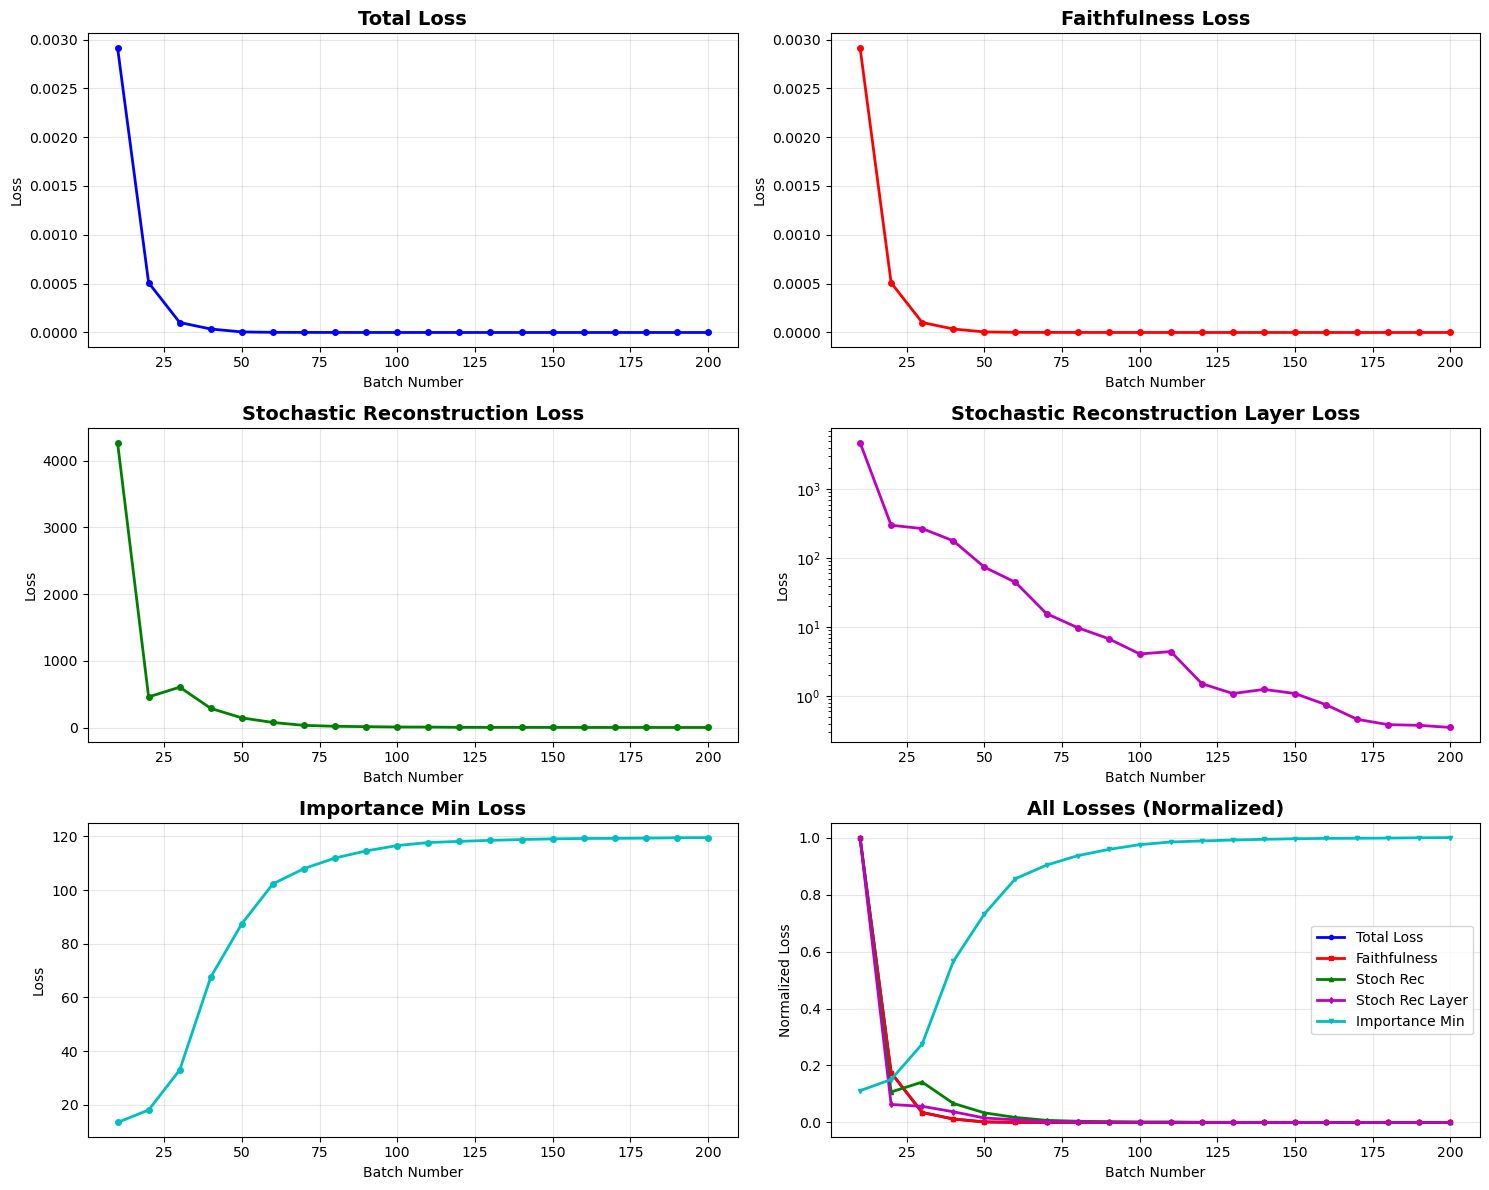

In [415]:
import matplotlib.pyplot as plt
import numpy as np


"""
for history in [loss_history, loss_history_stoch_rec, loss_history_stoch_rec_layer,loss_history_faithfulness,loss_history_imp_min]: 
    for idx, item in enumerate(history): 
        history[idx] = item.item()
"""

def plot_loss_histories(loss_history, loss_history_stoch_rec, loss_history_stoch_rec_layer, 
                       loss_history_faithfulness, loss_history_imp_min, save_interval=10):
    """
    Plot loss histories from saved lists
    
    Args:
        loss_history: List of total losses
        loss_history_stoch_rec: List of stochastic reconstruction losses  
        loss_history_stoch_rec_layer: List of stochastic reconstruction layer losses
        loss_history_faithfulness: List of faithfulness losses
        loss_history_imp_min: List of importance min losses
        save_interval: How often losses were saved (default 10 batches)
    """
    
    # Create batch numbers (assuming you save every save_interval batches)
    batch_numbers = [(i + 1) * save_interval for i in range(len(loss_history))]
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 12))
    
    # Plot total loss
    ax1.plot(batch_numbers, loss_history, 'b-', linewidth=2, marker='o', markersize=4)
    ax1.set_title('Total Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Batch Number')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    if max(loss_history) > 100:  # Use log scale for large values
        ax1.set_yscale('log')
    
    # Plot faithfulness loss
    ax2.plot(batch_numbers, loss_history_faithfulness, 'r-', linewidth=2, marker='o', markersize=4)
    ax2.set_title('Faithfulness Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Batch Number')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    if max(loss_history_faithfulness) > 100:
        ax2.set_yscale('log')
    
    # Plot stochastic reconstruction loss
    ax3.plot(batch_numbers, loss_history_stoch_rec, 'g-', linewidth=2, marker='o', markersize=4)
    ax3.set_title('Stochastic Reconstruction Loss', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Batch Number')
    ax3.set_ylabel('Loss')
    ax3.grid(True, alpha=0.3)
    
    # Plot stochastic reconstruction layer loss
    ax4.plot(batch_numbers, loss_history_stoch_rec_layer, 'm-', linewidth=2, marker='o', markersize=4)
    ax4.set_title('Stochastic Reconstruction Layer Loss', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Batch Number')
    ax4.set_ylabel('Loss')
    ax4.grid(True, alpha=0.3)
    if max(loss_history_stoch_rec_layer) > 100:
        ax4.set_yscale('log')
    
    # Plot importance min loss
    ax5.plot(batch_numbers, loss_history_imp_min, 'c-', linewidth=2, marker='o', markersize=4)
    ax5.set_title('Importance Min Loss', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Batch Number')
    ax5.set_ylabel('Loss')
    ax5.grid(True, alpha=0.3)
    
    # Plot all losses together (normalized)
    max_vals = [max(loss_history), max(loss_history_faithfulness), max(loss_history_stoch_rec), 
                max(loss_history_stoch_rec_layer), max(loss_history_imp_min)]
    
    if all(m > 0 for m in max_vals):  # Only plot if all have valid max values
        ax6.plot(batch_numbers, np.array(loss_history)/max(loss_history), 'b-', 
                linewidth=2, label='Total Loss', marker='o', markersize=3)
        ax6.plot(batch_numbers, np.array(loss_history_faithfulness)/max(loss_history_faithfulness), 'r-', 
                linewidth=2, label='Faithfulness', marker='s', markersize=3)
        ax6.plot(batch_numbers, np.array(loss_history_stoch_rec)/max(loss_history_stoch_rec), 'g-', 
                linewidth=2, label='Stoch Rec', marker='^', markersize=3)
        ax6.plot(batch_numbers, np.array(loss_history_stoch_rec_layer)/max(loss_history_stoch_rec_layer), 'm-', 
                linewidth=2, label='Stoch Rec Layer', marker='d', markersize=3)
        ax6.plot(batch_numbers, np.array(loss_history_imp_min)/max(loss_history_imp_min), 'c-', 
                linewidth=2, label='Importance Min', marker='v', markersize=3)
    
    ax6.set_title('All Losses (Normalized)', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Batch Number')
    ax6.set_ylabel('Normalized Loss')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig


fig = plot_loss_histories(loss_history, loss_history_stoch_rec, loss_history_stoch_rec_layer, 
                         loss_history_faithfulness, loss_history_imp_min)
# Example usage:
"""
# In your training loop, save losses every 10 batches like this:
if batch_idx % 10 == 0:
    loss_history.append(total_loss.item())
    loss_history_stoch_rec.append(stoch_rec_loss.item())
    loss_history_stoch_rec_layer.append(stoch_rec_layer_loss.item())
    loss_history_faithfulness.append(faithfulness_loss.item())
    loss_history_imp_min.append(imp_min_loss.item())

# Then plot:
fig = plot_loss_histories(loss_history, loss_history_stoch_rec, loss_history_stoch_rec_layer, 
                         loss_history_faithfulness, loss_history_imp_min)
"""

# Quick test with dummy data:
def test_plotter():
    # Create some example data
    n_points = 50
    batch_nums = range(10, 10 + n_points * 10, 10)
    
    # Simulate decreasing losses with some noise
    loss_history = [1000 * np.exp(-0.1 * i) + np.random.normal(0, 50) for i in range(n_points)]
    loss_history_faithfulness = [200 * np.exp(-0.15 * i) + np.random.normal(0, 10) for i in range(n_points)]
    loss_history_stoch_rec = [100 + 50 * np.sin(0.3 * i) + np.random.normal(0, 5) for i in range(n_points)]
    loss_history_stoch_rec_layer = [500 * np.exp(-0.08 * i) + np.random.normal(0, 20) for i in range(n_points)]
    loss_history_imp_min = [10 * np.exp(-0.05 * i) + np.random.normal(0, 1) for i in range(n_points)]
    
    return plot_loss_histories(loss_history, loss_history_stoch_rec, loss_history_stoch_rec_layer, 
                              loss_history_faithfulness, loss_history_imp_min)

# Uncomment to test:
# test_fig = test_plotter()